<h1 align="center">Text Summarization Using BART and T5 Models</h1>

## Table of Contents

>>[Set Up Environment](#scrollTo=SsVpRC8J_DZU)

>>[Import Libraries](#scrollTo=PbGJ1bnu_Gc2)

>>[Define Constants](#scrollTo=VWsWpAYv_IZc)

>>[Pre-training Evaluation](#scrollTo=K4cZWpvfIqKS)

>>[Training and Validation](#scrollTo=0gZy3HfozVvg)

>>[Model Training Time](#scrollTo=VtC1yrhbI4sg)

>>[Performance Evaluation](#scrollTo=5eDnQFxN0qkY)

>>[Improvement Rates of Models After Training](#scrollTo=0UEXydVrOkkq)

>>[Ablation Studies](#scrollTo=VJJ5-CfNvWnj)

>>[Select a Pre-trained Model](#scrollTo=oegXIDDi_M9Y)

>>[Summary](#scrollTo=1-N-G57g_Flj)



## 1. Set Up Environment

In [1]:
!pip install torch datasets transformers rouge-score

In [2]:
! pip install -U accelerate
! pip install -U transformers

## 2. Import Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import fileinput
import sys
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import datasets
from datasets import load_dataset, load_metric, Dataset
from datasets import load_from_disk
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration
from transformers import Trainer, TrainingArguments, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import pipeline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display, clear_output

## 3. Define Constants

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
HYPERS = {
    "BART-BASE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "BART-LARGE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "BART-LARGE-CNN": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "T5-SMALL": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "T5-BASE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "T5-LARGE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 512,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 50,
        "SUMMARY_ARTICLE_MAX_LENGTH": 512,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 50,
        "SUMMARY_HIGHLIGHT_BEAM": 2,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 2,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 2,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 2,
        "TRAIN_GENERATION_MAX_LENGTH": 50,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 50,
        "PIPELINE_MIN_LENGTH": 40,
    },

    "BART-LARGE-CNN-FREEZE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "BART-LARGE-CNN-DISCRIM": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },
}

## 4. Pre-training Evaluation

| Experiment Name | ROUGE1 | ROUGE2 | ROUGEL | ROUGELsum | Mean Generated Length |
| --- | --- | --- | --- | --- | --- |
| BART-BASE | 30.412231 | 11.955763 | 18.918125 | 25.038473 | 117.000000 |
| BART-LARGE | 28.677029 | 9.980131 | 18.635313 | 24.395673 | 117.066667 |
| BART-LARGE-CNN | 40.365079 | 16.988152 | 28.983233 | 34.358572 | 50.200000 |
| T5-SMALL | 28.825969 | 8.667316 | 20.115782 | 24.276790 | 45.066667 |
| T5-BASE | 35.604277 | 14.487096 | 26.491426 | 30.993596 | 42.733333 |
| T5-LARGE | 31.588141 | 11.039841 | 22.234351 | 26.753200 | 31.533333 |

- On average, the T5-type models perform better than the BART-type models. This is because T5 targets various tasks. As a result, BART needs fine-tuning on each task.

- While the T5 models benefit from their versatile nature, the BART-LARGE-CNN model outperforms all other methods as it was previously trained on the CNN/Daily Mail dataset.

- Within each group of models, the larger the network is, the better summarization results are achieved. Furthermore, more parameters represent a larger capacity of a model, which has a stronger expressive ability.

- However, the T5-LARGE model performs worse than the T5-BASE model. One possible reason is that the default generation length of the T5-LARGE model is shorter than the rest of the models in the T5 family. A shorter output length hinders the expressive ability of the model.


## 5. Training and Validation

In [9]:
step_list = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
model_list = ["BART-BASE", "BART-LARGE", "BART-LARGE-CNN", "T5-SMALL", "T5-BASE", "T5-LARGE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-DISCRIM"]
model_qualitative_list = ["BART-BASE", "BART-LARGE", "BART-LARGE-CNN", "T5-SMALL", "T5-BASE", "T5-LARGE"]

In [10]:
bart_base_data = {
    "Step": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    "Training Loss": [11.742400, 10.513400, 9.686400, 8.737300, 7.952600, 6.335300, 5.135400, 4.423100, 3.800400, 3.337200],
    "Validation Loss": [11.013391, 9.632937, 8.745844, 7.924075, 6.479474, 4.659436, 3.986900, 3.423099, 2.957968, 2.522966],
    "Model": ["BART-BASE", "BART-BASE", "BART-BASE", "BART-BASE", "BART-BASE", "BART-BASE", "BART-BASE", "BART-BASE", "BART-BASE", "BART-BASE"],
}
df_bart_base_data = pd.DataFrame.from_dict(bart_base_data)

bart_large_data = {
    "Step": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    "Training Loss": [11.696900, 10.525100, 9.338800, 8.463500, 7.487200, 6.359200, 5.521700, 4.887600, 4.560700, 4.240600],
    "Validation Loss": [11.346453, 9.655445, 8.563334, 7.558479, 6.223162, 4.912969, 4.427664, 4.106386, 3.820114, 3.524909],
    "Model": ["BART-LARGE", "BART-LARGE", "BART-LARGE", "BART-LARGE", "BART-LARGE", "BART-LARGE", "BART-LARGE", "BART-LARGE", "BART-LARGE", "BART-LARGE"],
}
df_bart_large_data = pd.DataFrame.from_dict(bart_large_data)

bart_large_cnn_data = {
    "Step": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    "Training Loss": [8.086400, 7.216500, 5.165500, 2.828300, 1.584700, 1.086200, 0.808900, 0.603600, 0.541800, 0.493900],
    "Validation Loss": [7.312938, 5.998803, 3.181171, 1.581215, 1.047528, 0.795684, 0.665296, 0.623622, 0.576892, 0.551481],
    "Model": ["BART-LARGE-CNN", "BART-LARGE-CNN", "BART-LARGE-CNN", "BART-LARGE-CNN", "BART-LARGE-CNN", "BART-LARGE-CNN", "BART-LARGE-CNN", "BART-LARGE-CNN", "BART-LARGE-CNN", "BART-LARGE-CNN"]
}
df_bart_large_cnn_data = pd.DataFrame.from_dict(bart_large_cnn_data)

t5_small_data = {
    "Step": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    "Training Loss": [11.360400, 11.754000, 11.106500, 10.228900, 9.579000, 8.197800, 7.172700, 5.758000, 4.536100, 3.250700],
    "Validation Loss": [12.827251, 12.447767, 11.822109, 10.953791, 9.857818, 8.539064, 7.001606, 5.324541, 3.595079, 2.127848],
    "Model": ["T5-SMALL", "T5-SMALL", "T5-SMALL", "T5-SMALL", "T5-SMALL", "T5-SMALL", "T5-SMALL", "T5-SMALL", "T5-SMALL", "T5-SMALL"]
}
df_t5_small_data = pd.DataFrame.from_dict(t5_small_data)

t5_base_data = {
    "Step": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    "Training Loss": [9.784900, 9.121500, 8.662500, 7.354700, 6.072200, 4.171600, 2.516600, 1.635000, 1.159400, 1.015100],
    "Validation Loss": [9.687448, 9.045111, 7.994954, 6.656920, 4.954986, 2.987519, 1.340967, 0.907747, 0.867435, 0.836667],
    "Model": ["T5-BASE", "T5-BASE", "T5-BASE", "T5-BASE", "T5-BASE", "T5-BASE", "T5-BASE", "T5-BASE", "T5-BASE", "T5-BASE"]
}
df_t5_base_data = pd.DataFrame.from_dict(t5_base_data)

t5_large_data = {
    "Step": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    "Training Loss": [5.081900, 4.363700, 4.229900, 3.903500, 3.485600, 3.512700, 3.654400, 3.030500, 2.850000, 2.948000],
    "Validation Loss": [4.484567, 4.179130, 3.862063, 3.599539, 3.390794, 3.213043, 3.073432, 2.929335, 2.864946, 2.771993],
    "Model": ["T5-LARGE", "T5-LARGE", "T5-LARGE", "T5-LARGE", "T5-LARGE", "T5-LARGE", "T5-LARGE", "T5-LARGE", "T5-LARGE", "T5-LARGE"]
}
df_t5_large_data = pd.DataFrame.from_dict(t5_large_data)

bart_large_cnn_freeze_data = {
    "Step": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    "Training Loss": [8.349900, 7.405800, 6.469800, 4.427000, 2.288300, 1.381900, 1.002400, 0.719200, 0.619300, 0.524900],
    "Validation Loss": [7.770353, 6.869614, 5.240678, 2.486506, 1.345228, 0.917387, 0.704649, 0.611553, 0.553761, 0.531625],
    "Model": ["BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-FREEZE"]
}
df_bart_large_cnn_freeze_data = pd.DataFrame.from_dict(bart_large_cnn_freeze_data)

bart_large_cnn_discrim_data = {
    "Step": [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    "Training Loss": [8.287100, 7.445000, 5.995400, 3.752000, 2.190800, 1.563800, 1.339700, 1.158900, 1.145600, 1.072200],
    "Validation Loss": [7.887224, 6.806077, 4.684964, 2.259639, 1.463958, 1.191350, 1.064174, 1.029142, 1.005842, 0.986026],
    "Model": ["BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM", "BART-LARGE-CNN-DISCRIM"]
}
df_bart_large_cnn_discrim_data = pd.DataFrame.from_dict(bart_large_cnn_discrim_data)

In [11]:
results = [df_bart_base_data, df_bart_large_data, df_bart_large_cnn_data, df_t5_small_data, df_t5_base_data, df_t5_large_data, df_bart_large_cnn_freeze_data, df_bart_large_cnn_discrim_data]
df_results = pd.concat(results, ignore_index=True)

In [12]:
model_widget = widgets.SelectMultiple(
    options=model_list,
    description="Model",
)

In [13]:
def f(model):
    # Initialization
    if (len(model) == 0):
        model = model_widget.options[0: 8]

    # Filter data
    df_plot = df_results[df_results["Model"].isin(model)]

    # Clear previous output
    clear_output(wait=True)

    # Define object-oriented interface
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.lineplot(data=df_plot, x="Step", y="Training Loss", hue="Model", palette="hls", marker="o", ax=axes[0])
    axes[0].xaxis.set_tick_params(length=0)
    axes[0].yaxis.set_tick_params(length=0)
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].plot(1, 0, ">k", transform=axes[0].transAxes, clip_on=False)
    axes[0].plot(0, 1, "^k", transform=axes[0].transAxes, clip_on=False)
    # axes[0].set_title("Training Loss", weight="bold")
    axes[0].set_xlabel("Steps", weight="bold")
    axes[0].set_ylabel("Training Loss", weight="bold")
    axes[0].grid(True, linestyle="--", linewidth=0.5)
    axes[0].legend(title="Models", title_fontsize="10", fontsize="8", loc="upper right")
    axes[0].set_xlim(0, 210)
    axes[0].set_ylim(0, 15)
    axes[0].set_xticks([20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
    axes[0].set_xticklabels([20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
    axes[0].set_yticks([2, 4, 6, 8, 10, 12, 14])
    axes[0].set_yticklabels([2, 4, 6, 8, 10, 12, 14])

    sns.lineplot(data=df_plot, x="Step", y="Validation Loss", hue="Model", palette="hls", marker="o", ax=axes[1])
    axes[1].xaxis.set_tick_params(length=0)
    axes[1].yaxis.set_tick_params(length=0)
    axes[1].spines[["right", "top"]].set_visible(False)
    axes[1].plot(1, 0, ">k", transform=axes[1].transAxes, clip_on=False)
    axes[1].plot(0, 1, "^k", transform=axes[1].transAxes, clip_on=False)
    # axes[1].set_title("Validation Loss", weight="bold")
    axes[1].set_xlabel("Steps", weight="bold")
    axes[1].set_ylabel("Validation Loss", weight="bold")
    axes[1].grid(True, linestyle="--", linewidth=0.5)
    axes[1].legend(title="Models", title_fontsize="10", fontsize="8", loc="upper right")
    axes[1].set_xlim(0, 210)
    axes[1].set_ylim(0, 15)
    axes[1].set_xticks([20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
    axes[1].set_xticklabels([20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
    axes[1].set_yticks([2, 4, 6, 8, 10, 12, 14])
    axes[1].set_yticklabels([2, 4, 6, 8, 10, 12, 14])

    # Adjust layout
    fig.tight_layout()

    # Display the figure
    plt.show()

In [14]:
# Define widget interaction function
interactive_widget = widgets.interactive(f, model=model_widget)

# Display the interactive widget
display(interactive_widget)

interactive(children=(SelectMultiple(description='Model', options=('BART-BASE', 'BART-LARGE', 'BART-LARGE-CNN'…

- Both training loss and validation loss are constantly decreasing, indicating no overfitting during the training. This is rare to see if we train a large model from scratch with a small dataset, proving the superiority of transfer learning methods.

- The BART-LARGE-CNN model and T5-BASE model are nearly converged on the dataset since their learning curves decline steadily at the beginning and then gradually level off.

- The T5-LARGE model still needs more training epochs to converge due to its huge parameter searching space.


## 6. Model Training Time

In the table below, I list the training time per sample and training time per step for each model.

Both training times are proportional to the models' sizes. Larger models need longer training time, especially during backpropagations.


| Experiment Name | Training Time Per Sample (s) | Training Time Per Step (s) |
| ---  | ---  | ---  |
| BART-BASE | 0.1932 | 0.7675 |
| BART-LARGE | 0.5838 | 2.3148 |
| BART-LARGE-CNN | 0.5679 | 2.2573 |
| T5-SMALL | 0.1102 | 0.4374 |
| T5-BASE | 0.4008 | 1.5924 |
| T5-LARGE | 1.5220 | 3.0442 |

## 7. Performance Evaluation


In this section, I evaluate the performances of different models after fine-tuning. I use the same evaluation metrics as the pre-training evaluation so that we can compare the learning processes.


| Experiment Name | ROUGE1 | ROUGE2 | ROUGEL | ROUGELsum | Mean Generated Length |
| --- | --- | --- | --- | --- | --- |
| BART-BASE | 28.994667 | 11.070305 | 21.819994 | 25.863156	 | 22.533333 |
| BART-LARGE | 33.582623 | 11.320112 | 21.748220 | 30.986846 | 50.400000 |
| BART-LARGE-CNN | **40.593942** | **19.043638** | **29.218974** | **38.051335** | **51.333333** |
| T5-SMALL | 29.184568 | 9.239417 | 21.137162 | 24.868365 | 45.333333 |
| T5-BASE | 33.297391 | 15.520506 | 24.143479 | 29.125728 | 49.866667 |
| T5-LARGE | 29.844413 | 10.481502 | 21.390539 | 26.458180 | 31.600000 |

- The BART-LARGE-CNN model provides the best results overall.

- The BART-LARGE model provides the second-best results in the experiment, followed by the T5-BASE model.

- The BART-BASE model and T5-SMALL model deliver the worst performance due to their limited learnable parameter spaces. As a result, we should only consider them when we want to cast a glance at a task.

- Similar to what we have observed in the pre-training evaluation, the model's performance increases with the capacity of the model.

- Worth noticing that the BART-LARGE model performs much better than the T5-LARGE model even though the BART-LARGE model only has 406M parameters, whereas the T5-LARGE model has 770M parameters, indicating that larger models are not necessarily the better ones.

## 8. Improvement Rates of Models After Training



| Experiment Name | Pre-training ROUGELsum | Post-training ROUGELsum | Improvement Rate (%) |
| --- | --- | --- | --- |
| BART-BASE | 25.038473 | 25.863156 | <font color="red">+3.29 &#8593;</font> |
| BART-LARGE | 24.395673 | 30.986846 | <font color="red">+27.02 &#8593;</font> |
| BART-LARGE-CNN | 34.358572 | 38.051335 | <font color="red">+10.75 &#8593;</font> |
| T5-SMALL | 24.276790 | 24.868365 | <font color="red">+2.44 &#8593;</font> |
| T5-BASE | 30.993596 | 29.125728 | <font color='blue'>-6.03 &#8595;</font> |
| T5-LARGE | 26.753200 | 26.458180 | <font color='blue'>-1.10 &#8595;</font> |

The improvement rates of models after training are shown in the above table.

- Surprisingly, the BART-BASE model picks up the most knowledge during the training process and surpasses the T5-BASE model and T5-LARGE model after fine-tuning. Considering that it has 406M parameters, it could be a nice choice to start with when dealing with a new task, balancing between the training expenses and final performance.

- Despite having the best performance before fine-tuning, BART-LARGE-CNN still has a 10.75% increment after the training. This proves the effectiveness of our training methods.

- All the BART family models benefit from the training, suggesting that BART has a better learning process. However, only the T5-SMALL model in the T5 family has better performance after training. This indicates that the T5 models are hard to train probably because of their Text-to-Text input and output scheme.

## 9. Ablation Studies

In the ablation studies, I compare the performance of models trained with and without advanced fine-tuning techniques including layer freezing and discriminative fine-tuning to identify the effectiveness of these methods.

- For the layer freezing, I freeze the first 6 layers in the encoder and decoder, respectively. Since I am using PyTorch, I set the "requires grad" attribute to "False" for the layers that are to be frozen.

- For the discriminative fine-tuning, I assign different learning rates to layers. The first 6 layers in the encoder and decoder are assigned a learning rate of 1e-5 and the last 6 layers in the encoder and decoder are assigned a learning rate of 3e-5.

As we can see from the diagrams below, all three models are steadily learning, but the model trained with standard methods has the lowest loss function.

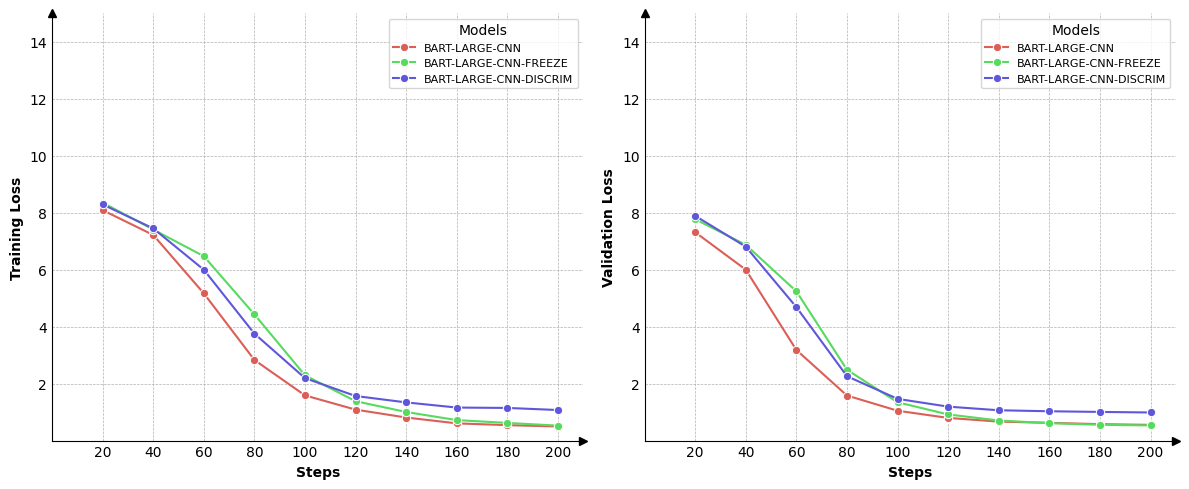

The experiment results reveal that the benefits of such methods are limited.

- Models trained with these methods do not outperform the models trained with standard methods.

- Advanced fine-tuning techniques can be useful but are not always beneficial. In the original BART and T5 papers, the authors did not use advanced fine-tuning techniques but still got exceptionally good results.

| Experiment Name | Pre-training ROUGELsum | Post-training ROUGELsum | Improvement Rate (%) |
| --- | --- | --- | --- |
| BART-LARGE-CNN | 34.358572 | 38.051335 | <font color="red">+10.74 &#8593;</font> |
| BART-LARGE-CNN-FREEZE | 34.358572 | 35.477216 | +3.26 &#8593; |
| BART-LARGE-CNN-DISCRIM | 34.358572 | 35.751566 | +4.05 &#8593; |

There are two possible explanations for this phenomenon.

- First, layer freezing restricts the gradients passing through the early layers, which could potentially harm the model's performance.

- Secondly, while layer freezing prevents overfitting when training a large model on a relatively small dataset, there are other techniques for regularization. Therefore, we can still reach good results without advanced fine-tuning techniques.

## 9. Select a Pre-trained Model

In this section, we conduct a qualitative evaluation of the results of the fine-tuned models. We can check the real-time generated summaries by selecting a model in the dropdown menu.

In [ ]:
# Example text to summarize
my_text = "The researchers developed a specialized microscopy technique for imaging multiple sides of the fossil antennae to better examine the ants’ sensilla — tiny projections that detect environmental cues. They compared the fossil ants’ suite of sensilla to those of six modern ant species. G. gracilis had two types of sensilla that are known only in ants. These organs are used for identifying nestmates and detecting their alarm pheromones, which notify other ants of threats to the colony. Together, these unique sensilla help ants live together and defend the colony as a single unit. Today, many ant species create massive colonies thousands to millions strong, but the researchers argue that the fossil record suggests that the earliest ants lived in very small colonies of a few dozen nestmates. Despite this, “we can consider that ants lived in a highly advanced social system even in their early evolutionary stages,” Taniguchi says. The new findings suggest that tens of millions of years before they became an ecological force in ecosystems around the world, ants may have been marching together."

# Initialize a tokenizer
bart_base_pretrained_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
# Initialize a model
bart_base_fine_tuned_model = BartForConditionalGeneration.from_pretrained("./" + str("BART-BASE")).to(device)
# Summarization pipeline
bart_base_summarizer = pipeline("summarization",
                            model=bart_base_fine_tuned_model,
                            tokenizer=bart_base_pretrained_tokenizer,
                            device=device)
# Generate summary
bart_base_my_summary = bart_base_summarizer(my_text,
                        max_length=HYPERS["BART-BASE"]["PIPELINE_MAX_LENGTH"],
                        min_length=HYPERS["BART-BASE"]["PIPELINE_MIN_LENGTH"],
                        do_sample=False)

# Initialize a tokenizer
bart_large_pretrained_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
# Initialize a model
bart_large_fine_tuned_model = BartForConditionalGeneration.from_pretrained("./" + str("BART-LARGE")).to(device)
# Summarization pipeline
bart_large_summarizer = pipeline("summarization",
                    model=bart_large_fine_tuned_model,
                    tokenizer=bart_large_pretrained_tokenizer,
                    device=device)
# Generate summary
bart_large_my_summary = bart_large_summarizer(my_text,
                        max_length=HYPERS["BART-LARGE"]["PIPELINE_MAX_LENGTH"],
                        min_length=HYPERS["BART-LARGE"]["PIPELINE_MIN_LENGTH"],
                        do_sample=False)

# Initialize a tokenizer
bart_large_cnn_pretrained_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
# Initialize a model
bart_large_cnn_fine_tuned_model = BartForConditionalGeneration.from_pretrained("./" + str("BART-LARGE-CNN")).to(device)
# Summarization pipeline
bart_large_cnn_summarizer = pipeline("summarization",
                    model=bart_large_cnn_fine_tuned_model,
                    tokenizer=bart_large_cnn_pretrained_tokenizer,
                    device=device)
# Generate summary
bart_large_cnn_my_summary = bart_large_cnn_summarizer(my_text,
                        max_length=HYPERS["BART-LARGE-CNN"]["PIPELINE_MAX_LENGTH"],
                        min_length=HYPERS["BART-LARGE-CNN"]["PIPELINE_MIN_LENGTH"],
                        do_sample=False)

# Initialize a tokenizer
t5_small_pretrained_tokenizer = T5Tokenizer.from_pretrained("t5-small")
# Initialize a model
t5_small_fine_tuned_model = T5ForConditionalGeneration.from_pretrained("./" + str("T5-SMALL")).to(device)
# Summarization pipeline
t5_small_summarizer = pipeline("summarization",
                    model=t5_small_fine_tuned_model,
                    tokenizer=t5_small_pretrained_tokenizer,
                    device=device)
# Generate summary
t5_small_my_summary = t5_small_summarizer(my_text,
                        max_length=HYPERS["T5-SMALL"]["PIPELINE_MAX_LENGTH"],
                        min_length=HYPERS["T5-SMALL"]["PIPELINE_MIN_LENGTH"],
                        do_sample=False)

# Initialize a tokenizer
t5_base_pretrained_tokenizer = T5Tokenizer.from_pretrained("t5-base")
# Initialize a model
t5_base_fine_tuned_model = T5ForConditionalGeneration.from_pretrained("./" + str("T5-BASE")).to(device)
# Summarization pipeline
t5_base_summarizer = pipeline("summarization",
                    model=t5_base_fine_tuned_model,
                    tokenizer=t5_base_pretrained_tokenizer,
                    device=device)
# Generate summary
t5_base_my_summary = t5_base_summarizer(my_text,
                        max_length=HYPERS["T5-BASE"]["PIPELINE_MAX_LENGTH"],
                        min_length=HYPERS["T5-BASE"]["PIPELINE_MIN_LENGTH"],
                        do_sample=False)

# Initialize a tokenizer
t5_large_pretrained_tokenizer = T5Tokenizer.from_pretrained("t5-large")
# Initialize a model
t5_large_fine_tuned_model = T5ForConditionalGeneration.from_pretrained("./" + str("T5-LARGE")).to(device)
# Summarization pipeline
t5_large_summarizer = pipeline("summarization",
                    model=t5_large_fine_tuned_model,
                    tokenizer=t5_large_pretrained_tokenizer,
                    device=device)
# Generate summary
t5_large_my_summary = t5_large_summarizer(my_text,
                        max_length=HYPERS["T5-LARGE"]["PIPELINE_MAX_LENGTH"],
                        min_length=HYPERS["T5-LARGE"]["PIPELINE_MIN_LENGTH"],
                        do_sample=False)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [16]:
model_text_widget = widgets.Dropdown(
    options=model_qualitative_list,
    value="BART-LARGE-CNN",
    description="Model",
)

def k(model):
    MODEL_SELECTED = model

    if MODEL_SELECTED == "BART-BASE":
        # Summarization pipeline
        summarizer = bart_base_summarizer
        my_summary = bart_base_my_summary
    elif MODEL_SELECTED == "BART-LARGE":
        # Summarization pipeline
        summarizer = bart_large_summarizer
        my_summary = bart_large_my_summary
    elif MODEL_SELECTED == "BART-LARGE-CNN":
        # Summarization pipeline
        summarizer = bart_large_cnn_summarizer
        my_summary = bart_large_cnn_my_summary
    elif MODEL_SELECTED == "T5-SMALL":
        # Summarization pipeline
        summarizer = t5_small_summarizer
        my_summary = t5_small_my_summary
    elif MODEL_SELECTED == "T5-BASE":
        # Summarization pipeline
        summarizer = t5_base_summarizer
        my_summary = t5_base_my_summary
    elif MODEL_SELECTED == "T5-LARGE":
        # Summarization pipeline
        summarizer = t5_large_summarizer
        my_summary = t5_large_my_summary
    else:
        raise ValueError("Please input correct model name")

    my_results = pd.DataFrame({"Summary": my_summary, "Article": my_text})

    with pd.option_context('display.max_colwidth', None):
        styled_my_results = my_results.style.format()
        display(styled_my_results.hide())


In [17]:
# Define widget interaction function
interactive_text_widget = widgets.interactive(k, model=model_text_widget)

# Display the interactive widget
display(interactive_text_widget)

interactive(children=(Dropdown(description='Model', index=2, options=('BART-BASE', 'BART-LARGE', 'BART-LARGE-C…

As we can see, the above summary is a simpler abstractive summarization of the original content while preserving key information. This proves the effectiveness of the training process.

## 10. Summary

- Transfer learning and fine-tuning are indispensable techniques in the contemporary AI industry.

- Both BART and T5 generate readable and fluent content with a good balance between extractive and abstractive summarization.

- T5 is a good starting point for various tasks due to its versatile nature.

- BART is easy to train with a stable training process while training T5 is harder due to its Text-to-Text design and larger parameter space.

- A larger model is not necessarily to be the better one. Larger models need more training time and are harder to converge on smaller datasets.

- Advanced fine-tuning techniques, like layer freezing and discriminative fine-tuning, can be useful but are not always beneficial.